# K4CV : 4-circle kappa diffractometer example

The kappa geometry replaces the traditional $\chi$-ring on a 4-circle
diffractometer with an alternative kappa stage that holds the phi stage. The kappa stage is tilted at angle $\alpha$ (typically 50 degrees) from the $\omega$ stage.

----

Note:  This example is available as a
[Jupyter notebook](https://jupyter.org/) from the *hklpy* source
code website: https://github.com/bluesky/hklpy/tree/main/examples

## Load the *hklpy* package (named _`hkl`_)

Since the *hklpy* package is a thin interface to the *hkl*
library (compiled C++ code), we need to **first** load the
*gobject-introspection* package (named _`gi`_) and name our
required code and version.

This is needed _every_ time before the *hkl* package is first imported.

In [1]:
import gi
gi.require_version('Hkl', '5.0')

## Setup the *K4CV* diffractometer in *hklpy*

In _hkl_ *K4CV* geometry (https://people.debian.org/~picca/hkl/hkl.html#org723c5b9):

![K4CV geometry](resources/k4cv.png)

For this geometry there is a special parameter $\alpha$, the angle between the kappa rotation axis and the $\vec{y}$ direction.

axis  | moves    | rotation axis    | vector
---   | :---     | :---:            | :---
komega | sample   | $-\vec{y}$      | `[0 -1 0]`
kappa   | sample   | $\vec{x}$      | `[0 -0.6428 -0.7660]`
kphi   | sample   | $-\vec{y}$      | `[0 -1 0]`
tth   | detector | $-\vec{y}$       | `[0 -1 0]`


## Define _this_ diffractometer

Create a Python class that specifies the names of the 
real-space positioners.  We call it `KappaFourCircle` here but that
choice is arbitrary.  Pick any valid Python name not already in use.

The argument to the `KappaFourCircle` class tells which *hklpy* base
class will be used.  This sets the geometry.  See the
[*hklpy* diffractometers documentation](https://blueskyproject.io/hklpy/master/diffract.html#hkl.diffract.Diffractometer.calc_class)
for a list of other choices.

In *hklpy*, the reciprocal-space axes
are known as `pseudo` positioners while the real-space axes
are known as `real` positioners.  For the real positioners,
it is possible to use different names than the canonical names
used internally by the *hkl* library.  That is not covered here.

note: The keyword argument `kind="hinted"` is an indication
that this signal may be plotted and appear in the live table.

This demo uses simulated motors.
To use EPICS motors, import that structure from *ophyd*:

```python
from ophyd import EpicsMotor
```

Then, in the class, replace the real positioners with (substituting with the correct EPICS PV for each motor):

```python
komega = Cpt(EpicsMotor, "pv_prefix:m41", kind="hinted")
kappa = Cpt(EpicsMotor, "pv_prefix:m22", kind="hinted")
kphi = Cpt(EpicsMotor, "pv_prefix:m35", kind="hinted")
tth = Cpt(EpicsMotor, "pv_prefix:m7", kind="hinted")
```

and, **most important**, remove the `def __init__()` method.
It is only needed to define an initial position for the simulators.
Otherwise, this will move these EPICS motors to zero.

In [2]:
from hkl.diffract import K4CV
from ophyd import PseudoSingle, SoftPositioner
from ophyd import Component as Cpt

class KappaFourCircle(K4CV):
    """
    Our kappa 4-circle.  Eulerian, vertical scattering orientation.
    """
    # the reciprocal axes are called: pseudo in hklpy
    h = Cpt(PseudoSingle, '', kind="hinted")
    k = Cpt(PseudoSingle, '', kind="hinted")
    l = Cpt(PseudoSingle, '', kind="hinted")

    # the motor axes are called: real in hklpy
    komega = Cpt(SoftPositioner, kind="hinted")
    kappa = Cpt(SoftPositioner, kind="hinted")
    kphi = Cpt(SoftPositioner, kind="hinted")
    tth = Cpt(SoftPositioner, kind="hinted")

    def __init__(self, *args, **kwargs):
        """Define an initial position for simulators."""
        super().__init__(*args, **kwargs)

        for p in self.real_positioners:
            p._set_position(0)  # give each a starting position

In [3]:
k4cv = KappaFourCircle("", name="k4cv")

## Add a sample with a crystal structure

In [4]:
from hkl.util import Lattice

# add the sample to the calculation engine
a0 = 5.431
k4cv.calc.new_sample(
    "silicon",
    lattice=Lattice(a=a0, b=a0, c=a0, alpha=90, beta=90, gamma=90)
    )

HklSample(name='silicon', lattice=LatticeTuple(a=5.431, b=5.431, c=5.431, alpha=90.0, beta=90.0, gamma=90.0), ux=Parameter(name='None (internally: ux)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uy=Parameter(name='None (internally: uy)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uz=Parameter(name='None (internally: uz)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), U=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), UB=array([[ 1.15691131e+00, -7.08403864e-17, -7.08403864e-17],
       [ 0.00000000e+00,  1.15691131e+00, -7.08403864e-17],
       [ 0.00000000e+00,  0.00000000e+00,  1.15691131e+00]]), reflections=[])

## Setup the UB orientation matrix using *hklpy*

Define the crystal's orientation on the diffractometer using 
the 2-reflection method described by [Busing & Levy, Acta Cryst 22 (1967) 457](https://www.psi.ch/sites/default/files/import/sinq/zebra/PracticalsEN/1967-Busing-Levy-3-4-circle-Acta22.pdf).

### Choose the same wavelength X-rays for both reflections

In [5]:
k4cv.calc.wavelength = 1.54  # Angstrom (8.0509 keV)

### Find the first reflection and identify its Miller indices: (_hkl_)

In [6]:
r1 = k4cv.calc.sample.add_reflection(
    4, 0, 0,
    position=k4cv.calc.Position(
        tth=-69.0966,
        komega=55.4507,
        kappa=0,
        kphi=-90,
    )
)

### Find the second reflection

In [7]:
r2 = k4cv.calc.sample.add_reflection(
    0, 4, 0,
    position=k4cv.calc.Position(
        tth=-69.0966,
        komega=-1.5950,
        kappa=134.7568,
        kphi=123.3554
    )
)

### Compute the *UB* orientation matrix

The `compute_UB()` method always returns 1.  Ignore it.

In [8]:
k4cv.calc.sample.compute_UB(r1, r2)

1

## Report what we have setup

In [9]:
import pyRestTable

tbl = pyRestTable.Table()
tbl.labels = "term value".split()
tbl.addRow(("energy, keV", k4cv.calc.energy))
tbl.addRow(("wavelength, angstrom", k4cv.calc.wavelength))
tbl.addRow(("position", k4cv.position))
tbl.addRow(("sample name", k4cv.sample_name.get()))
tbl.addRow(("[U]", k4cv.U.get()))
tbl.addRow(("[UB]", k4cv.UB.get()))
tbl.addRow(("lattice", k4cv.lattice.get()))
print(tbl)

print(f"sample\t{k4cv.calc.sample}")

==================== ===================================================
term                 value                                              
==================== ===================================================
energy, keV          0.8050922077922078                                 
wavelength, angstrom 1.54                                               
position             KappaFourCirclePseudoPos(h=0.0, k=-0.0, l=0.0)     
sample name          silicon                                            
[U]                  [[ 1.74532925e-05 -6.22695871e-06 -1.00000000e+00] 
                      [ 0.00000000e+00 -1.00000000e+00  6.22695872e-06] 
                      [-1.00000000e+00 -1.08680932e-10 -1.74532925e-05]]
[UB]                 [[ 2.01919115e-05 -7.20403894e-06 -1.15691131e+00] 
                      [ 0.00000000e+00 -1.15691131e+00  7.20403894e-06] 
                      [-1.15691131e+00 -1.25734128e-10 -2.01919115e-05]]
lattice              [ 5.431  5.431  5.431 90.    9

## Check the orientation matrix

Perform checks with _forward_ (hkl to angle) and
_inverse_ (angle to hkl) computations to verify the diffractometer
will move to the same positions where the reflections were identified.

### Use `bissector` mode

where `tth` = 2*`omega`


In [10]:
k4cv.calc.engine.mode = "bissector"

### (400) reflection test

1. Check the `inverse` (angles -> (_hkl_)) computation.
1. Check the `forward` ((_hkl_) -> angles) computation.

### Check the inverse calculation: (400)

To calculate the (_hkl_) corresponding to a given set of motor angles,
call `k4cv.inverse((h, k, l))`.  Note the second set of parentheses needed by this function.

The values are specified, without names, in the order specified
by `k4cv.calc.physical_axis_names`.

In [11]:
print("axis names:", k4cv.calc.physical_axis_names)

axis names: ['komega', 'kappa', 'kphi', 'tth']


Now, proceed with the inverse calculation.

In [12]:
sol = k4cv.inverse((55.4507, 0, -90, -69.0966))
print("(4 0 0) ?", f"{sol.h:.2f}", f"{sol.k:.2f}", f"{sol.l:.2f}")


(4 0 0) ? 4.00 -0.00 -0.00


### Check the forward calculation: (400)

Compute the angles necessary to position the diffractometer
for the given reflection.

Note that for the forward computation, more than one set of angles may be used to reach the same crystal reflection.  This test will report the *default* selection.  The *default* selection (which may be changed through methods described in the `hkl.calc` module) is the first solution.

function | returns
--- | ---
`k4cv.forward()` | The *default* solution
`k4cv.calc.forward()` | List of all allowed solutions.

In [13]:
sol = k4cv.forward((4, 0, 0))
print(
    "(400) :", 
    f"tth={sol.tth:.4f}", 
    f"komega={sol.komega:.4f}", 
    f"kappa={sol.kappa:.4f}", 
    f"kphi={sol.kphi:.4f}"
    )

(400) : tth=-69.0985 komega=55.4507 kappa=0.0000 kphi=-90.0010


### (040) reflection test

Repeat the `inverse` and `forward` calculations for the
second orientation reflection.

### Check the inverse calculation: (040)

In [14]:
sol = k4cv.inverse((-1.5950, 134.7568, 123.3554, -69.0966))
print("(0 4 0) ?", f"{sol.h:.2f}", f"{sol.k:.2f}", f"{sol.l:.2f}")

(0 4 0) ? -0.00 4.00 0.00


### Check the forward calculation: (040)

In [15]:
sol = k4cv.forward((0, 4, 0))
print(
    "(040) :", 
    f"tth={sol.tth:.4f}", 
    f"komega={sol.komega:.4f}", 
    f"kappa={sol.kappa:.4f}", 
    f"kphi={sol.kphi:.4f}"
    )

(040) : tth=-69.0985 komega=-1.5939 kappa=134.7551 kphi=-57.3291


## Scan in reciprocal space using Bluesky

To scan with Bluesky, we need more setup.

In [16]:
%matplotlib inline

from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky.callbacks.best_effort import BestEffortCallback
import bluesky.plans as bp
import bluesky.plan_stubs as bps
import databroker
import matplotlib.pyplot as plt

plt.ion()

bec = BestEffortCallback()
db = databroker.temp().v1
sd = SupplementalData()

RE = RunEngine({})
RE.md = {}
RE.preprocessors.append(sd)
RE.subscribe(db.insert)
RE.subscribe(bec)

1

### (_h00_) scan near (400)

In [17]:
RE(bp.scan([], k4cv.h, 3.9, 4.1, 5))



Transient Scan ID: 1     Time: 2020-12-16 22:12:37
Persistent Unique Scan ID: '6b8882a1-50b7-44cd-8735-af19b817d80a'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     k4cv_h |
+-----------+------------+------------+
|         1 | 22:12:37.5 |      3.900 |
|         2 | 22:12:37.6 |      3.950 |
|         3 | 22:12:37.7 |      4.000 |
|         4 | 22:12:37.8 |      4.050 |
|         5 | 22:12:37.9 |      4.100 |
+-----------+------------+------------+
generator scan ['6b8882a1'] (scan num: 1)





('6b8882a1-50b7-44cd-8735-af19b817d80a',)

### (_hk0_) scan from (400) to (040)

Scan between the two orientation reflections.  Need to
keep $\varphi\ge0$ to avoid big jumps during the scan.



Transient Scan ID: 2     Time: 2020-12-16 22:12:38
Persistent Unique Scan ID: '739bc088-6174-4f65-9959-7c8d731943a5'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |     k4cv_h |     k4cv_k |     k4cv_l | k4cv_komega | k4cv_kappa |  k4cv_kphi |   k4cv_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 22:12:38.5 |      4.000 |      0.000 |      0.000 |    -124.550 |     -0.000 |     90.000 |    -69.099 |
|         2 | 22:12:39.0 |      3.556 |      0.444 |      0.000 |    -117.539 |     -9.305 |     92.995 |    -61.065 |
|         3 | 22:12:39.5 |      3.111 |      0.889 |      0.000 |    -110.558 |    -20.863 |     96.749 |    -54.612 |
|         4 | 22:12:40.1 |      2.667 |      1.333 |     -0.000 |    -103.581 |    -34.906 |    101.425 |    -50.011 |
|         5 | 22:12:40.7 |

('739bc088-6174-4f65-9959-7c8d731943a5',)

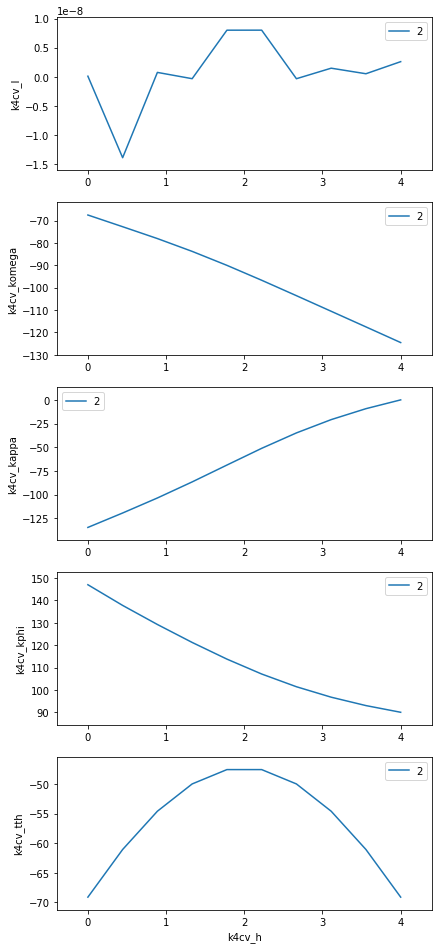

In [18]:
k4cv.calc.engine.mode = "constant_phi"
k4cv.calc["kphi"].limits = (0, 180)

RE(bp.scan([k4cv.h, k4cv.k, k4cv.l, k4cv.komega,k4cv.kappa,k4cv.kphi, k4cv.tth], k4cv.h, 4, 0, k4cv.k, 0, 4, 10))

### (_0k0_) scan near (040)

In [19]:
RE(bp.scan([], k4cv.k, 3.9, 4.1, 5))



Transient Scan ID: 3     Time: 2020-12-16 22:12:45
Persistent Unique Scan ID: '79ae2e4d-0547-4db8-83ed-64070e573825'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     k4cv_k |
+-----------+------------+------------+
|         1 | 22:12:45.2 |      3.900 |
|         2 | 22:12:45.3 |      3.950 |
|         3 | 22:12:45.3 |      4.000 |
|         4 | 22:12:45.3 |      4.050 |
|         5 | 22:12:45.4 |      4.100 |
+-----------+------------+------------+
generator scan ['79ae2e4d'] (scan num: 3)





('79ae2e4d-0547-4db8-83ed-64070e573825',)

### (_hk0_) scan near (440)



Transient Scan ID: 4     Time: 2020-12-16 22:12:45
Persistent Unique Scan ID: 'ce52bb00-a84b-40a1-8494-8d2e71263ef4'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |     k4cv_h |     k4cv_k |     k4cv_l | k4cv_komega | k4cv_kappa |  k4cv_kphi |   k4cv_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 22:12:45.9 |      3.900 |      4.100 |      0.000 |    -122.253 |    -61.940 |    111.095 |   -106.695 |
|         2 | 22:12:46.5 |      3.950 |      4.050 |      0.000 |    -122.615 |    -60.940 |    110.715 |   -106.659 |
|         3 | 22:12:47.0 |      4.000 |      4.000 |      0.000 |    -122.985 |    -59.941 |    110.339 |   -106.647 |
|         4 | 22:12:47.6 |      4.050 |      3.950 |     -0.000 |    -123.366 |    -58.946 |    109.965 |   -106.659 |
|         5 | 22:12:48.2 |

('ce52bb00-a84b-40a1-8494-8d2e71263ef4',)

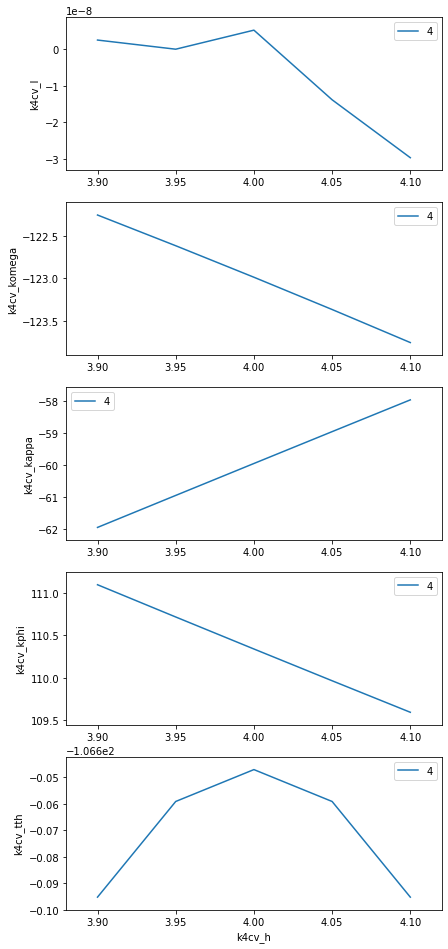

In [20]:
RE(bp.scan([], k4cv.h, 3.9, 4.1, k4cv.k, 4.1, 3.9, 5))